In [ ]:
# !pip install dotenv
# !pip install -qU langchain-tavily
# https://wikidocs.net/264624 작업


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\kevin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

### 1. TavilySearchResults 검색 API 도구 사용

In [6]:
from langchain_tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

In [7]:
tool.invoke({"query": "What happened Korean President"})

{'query': 'What happened Korean President',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "South Korea's president removed from power: What happens now?",
   'url': 'https://www.msn.com/en-us/news/world/south-koreas-president-removed-from-power-what-happens-now/ar-AA1ChC1R',
   'content': "South Korea's president has been removed from office after the Constitutional Court voted unanimously to uphold his impeachment. Yoon Suk Yeol was suspended from duty in December after being",
   'score': 0.7636429,
   'raw_content': None},
  {'title': "Yoon Suk Yeol: South Korea's impeached president is removed ... - CNN",
   'url': 'https://www.cnn.com/2025/04/03/asia/yoon-impeachment-verdict-south-korea-intl-hnk',
   'content': "Yoon Suk Yeol: South Korea’s impeached president is removed from office, four months after declaring martial law | CNN South Korea's Constitutional Court unanimously removed President Yoon Suk Yeol from office Friday following his bri

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_ollama import ChatOllama

# LLM 초기화
llm = ChatOllama(model="mistral:latest", temperature=0, base_url = "http://192.168.1.203:11434")
# llm = ChatOllama(model="qwq:latest", temperature=0, base_url = "http://192.168.1.203:11434")

llm_with_tools = llm.bind_tools(tools)  

In [49]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

In [50]:
# 그래프 생성 및 노드를 추가
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

### 2. 도구 노드(Tool Node)
- 다음으로, 도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 합니다. 이를 위해 새로운 노드에 도구를 추가합니다.
- 가장 최근의 메시지를 확인하고 메시지에 tool_calls가 포함되어 있으면 도구를 호출하는 BasicToolNode를 구현
- 지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 ToolNode 로 대체할 수 있습니다.

In [51]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

### 3. 조건부 엣지(Conditional Edge)
1) Edges는 한 노드에서 다음 노드로 제어 흐름을 라우팅합니다.
2) Conditional edges는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅합니다. 
3) 이러한 함수는 현재 그래프 state를 받아 다음에 호출할 Node 를 나타내는 문자열 또는 문자열 목록 을 반환합니다.
4) 조건은 도구 호출이 있으면 tools로, 없으면 END로 라우팅


In [52]:
from langgraph.graph import START, END

# route_tools라는 라우터 함수를 정의하여 챗봇의 출력에서 tool_calls를 확인
def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# tools_condition 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

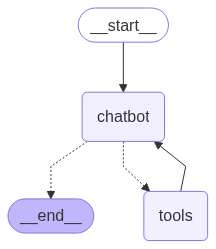

In [53]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
question = "한국의 다음 대통령 선거"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        print(value["messages"][-1])


STEP: chatbot

content='' additional_kwargs={} response_metadata={'model': 'mistral:latest', 'created_at': '2025-05-29T23:33:29.867168041Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3835041427, 'load_duration': 21892647, 'prompt_eval_count': 956, 'prompt_eval_duration': 391000000, 'eval_count': 235, 'eval_duration': 3419000000, 'model_name': 'mistral:latest'} id='run--ead765bc-b71a-4df8-8b5c-62038d498b95-0' tool_calls=[{'name': 'tavily_search', 'args': {'include_images': False, 'query': '2022 대한민국 대통령 선거', 'search_depth': 'advanced'}, 'id': '30e59670-014f-44e5-9620-5e2254b8326f', 'type': 'tool_call'}] usage_metadata={'input_tokens': 956, 'output_tokens': 235, 'total_tokens': 1191}

STEP: tools

content='{"query": "2022 대한민국 대통령 선거", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD_%EC%A0%9C20%EB%8C%80_%EB%8C%80%ED%86%B5%EB%A0%B9_%EC%84%A0%EA%B1%B0", "title": "대한민국 제20대 대통령 선